In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

In [2]:
# Load YOLO model
model = YOLO("yolov8n.pt")

In [3]:
# Input image
img_path = "night_car.jpeg"  # change if needed
results = model(img_path)

# Get detections (bounding boxes)
detections = results[0].boxes.xyxy.cpu().numpy().astype(int)


image 1/1 E:\Projects\Smart Grid Headlights\night_car.jpeg: 384x640 1 car, 37.2ms
Speed: 36.5ms preprocess, 37.2ms inference, 221.4ms postprocess per image at shape (1, 3, 384, 640)


In [4]:
# Load image
orig_img = cv2.imread(img_path)
H, W, _ = orig_img.shape

In [5]:
# Define LED panel resolution
GRID_W, GRID_H = 16, 12

# Initialize LED panel (bright background)
led_panel = np.ones((GRID_H, GRID_W)) * 255  

# For each detection box, darken inside and fade outward
for (x1, y1, x2, y2) in detections:
    gx1, gy1 = int(x1 * GRID_W / W), int(y1 * GRID_H / H)
    gx2, gy2 = int(x2 * GRID_W / W), int(y2 * GRID_H / H)

    for gy in range(GRID_H):
        for gx in range(GRID_W):
            dx = max(gx1 - gx, 0, gx - gx2)
            dy = max(gy1 - gy, 0, gy - gy2)
            dist = np.sqrt(dx*dx + dy*dy)

            intensity = min(255, dist * 60)  # sharper fade
            led_panel[gy, gx] = min(led_panel[gy, gx], intensity)

In [6]:
# Smooth upscale LED panel

panel_display = cv2.resize(
    led_panel.astype(np.uint8), (W, H), interpolation=cv2.INTER_LINEAR
)

# Convert LED grayscale to 3-channel (for blending)
led_colored = cv2.cvtColor(panel_display, cv2.COLOR_GRAY2BGR)

# Blend with original image
alpha = 0.6  
overlay_img = cv2.addWeighted(orig_img, 1 - alpha, led_colored, alpha, 0)

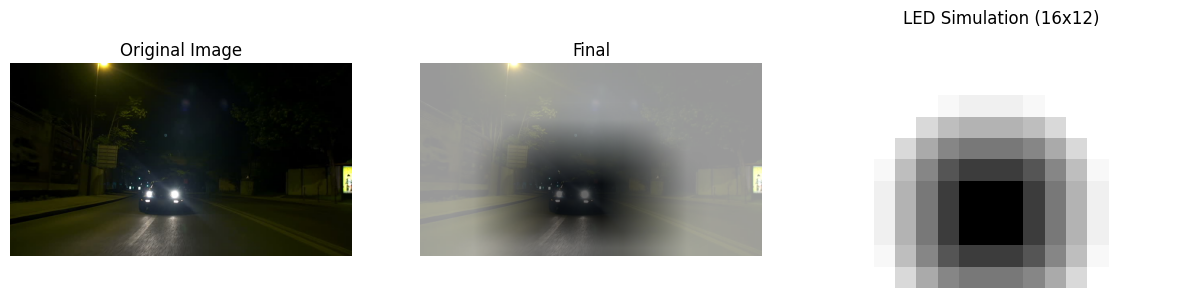

In [7]:
# Show results
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Final")
plt.imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,3,3)
plt.title("LED Simulation (16x12)")
plt.imshow(led_panel, cmap="gray", interpolation="nearest")
plt.axis("off")

plt.show()